# Probablistic Model

In [1]:
!pip install ray[tune]
import math
import torch
import numpy as np
import pandas as pd
import tensorflow as tf
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn import preprocessing
from Training import model, utils, dataset, train
from sklearn.model_selection import train_test_split


import keras.backend as K

In [22]:
def check_acc(y_hat,y,margin=0.05):
    a_err = (np.abs(y_hat - y)) # get normalized error 
    err = np.divide(a_err, y, out=a_err, where=y!=0)
    assert(err.shape == y.shape)
    num_correct = 0
    for row in err:
        num_in_row = len(np.where(row < margin)[0]) # margin * 100 because 
        if num_in_row == len(row):
            num_correct += 1

    num_samples = y.shape[0]
    correct_idx = np.where(err < margin)
    num_part_correct = len(correct_idx[0])
    num_part_samples = y.shape[0] * y.shape[1]
    print(f"Correct = {num_correct} / {num_samples}")
    return (num_correct/num_samples)
from matplotlib.patches import Ellipse
def multivariate_gaussian_nll(ypreds, ytrue, var):
    
    diag = torch.exp(var[:,:2]) # convert log-scale var to
    n = ypreds.shape[1] #number of parameters ie number of means (2 gain and bandwidth)
    B = ypreds.shape[0] #Batch size
    
    z = torch.zeros(B)
    o = torch.ones(B)
    D = torch.stack((diag[:,0],z,z,diag[:,1]),dim=1).reshape(B,2,2) # form Diagnol matrix D for LDLT
    L = torch.stack((o,z,var[:,2],o),dim=1).reshape(B,2,2) # form L matrix 
    LT = torch.stack((o,var[:,2],z,o),dim=1).reshape(B,2,2) # form LT matrix (transpose of L)

    sigma = L @ D @ LT   # form sigma inv from LDLT decomp
    ximu =(ytrue-ypreds).reshape(B,2,1)  #true- minus 
    ximuT =(ytrue-ypreds).reshape(B,1,2) # true- minus  transpose

    loss = 0.5*torch.mean(ximuT@sigma@ximu + ((n/2)*(-torch.sum(var[:,:2],axis=1).reshape(B,1))))
    return loss
def formCovMatrix(var):
    diag = np.exp(var[:2])
    z = np.zeros(2)
    o = np.ones(2)
    D = np.array([diag[0],0,0,diag[1]]).reshape(2,2)
    L = np.array([1,0,var[2],1]).reshape(2,2)
    LT = np.array([1,var[2],0,1]).reshape(2,2)
    sigma = L @ D @ LT
    return np.linalg.pinv(sigma)

#### Load Data

In [23]:
data_raw = utils.parseGainAndBWCsv2("Data/BW-3000.csv").astype(float)

In [24]:
print(data_raw.min(axis=0))

[ 6.200e+02  2.880e-06 -1.823e+00  3.240e+10]


##### Split data into inputs X and target Y Normalize to [0,1] (inclusive) and create Training and Testign Splits.  
Save scaler to denormalize data later



In [25]:
data = preprocessing.MinMaxScaler((0,1)).fit_transform(data_raw)
scaler = preprocessing.MinMaxScaler((0,1))
data2 = scaler.fit_transform(data_raw)
assert(np.allclose(data,data2))
X = data[:,:2]
Y = data[:,2:]

#### Define Model and Parameters

##### Define model

* Model: MLP with variable hidden layer number and width  
* Output layer: 
    * Node 1 and 2 are the mean for probability mean 
    * Node 3-5 are values of the covariance matrix


In [29]:
test_model = model.DistModelBatchNorm(2,5)

##### Define Loss

* Loss: guassian_nll


In [30]:
optimizer = optim.Adagrad(test_model.parameters(),lr=0.001)
loss_fn = multivariate_gaussian_nll

dataset1 = dataset.CircuitSynthesisGainAndBandwidthManually(Y, X)
train_dataset, val_dataset = utils.splitDataset(dataset1, 0.95)
    
train_data = DataLoader(train_dataset,batch_size = 500)
validation_data = DataLoader(val_dataset, batch_size = 500)

In [31]:
epochs = 700
loss_list, val_loss_list = train.trainProbModel(test_model, train_data, loss_fn, optimizer, num_epochs=epochs, print_every=10, validation_data=validation_data)

t = 10, loss = -1.5089, val loss = -1.5953
t = 20, loss = -2.1927, val loss = -2.1924
t = 30, loss = -2.6012, val loss = -2.6085
t = 40, loss = -2.9961, val loss = -3.0425
t = 50, loss = -3.2710, val loss = -3.3354
t = 60, loss = -3.5954, val loss = -3.6045
t = 70, loss = -3.7100, val loss = -3.6729
t = 80, loss = -3.9868, val loss = -4.0325
t = 90, loss = -4.1911, val loss = -4.3061
t = 100, loss = -4.3278, val loss = -4.4282
t = 110, loss = -4.4960, val loss = -4.4902
t = 120, loss = -4.6651, val loss = -4.6493
t = 130, loss = -4.6856, val loss = -4.7424
t = 140, loss = -4.9708, val loss = -5.0562
t = 150, loss = -4.9958, val loss = -5.1072
t = 160, loss = -5.2054, val loss = -5.1071
t = 170, loss = -5.2188, val loss = -5.3133
t = 180, loss = -5.3816, val loss = -5.4157
t = 190, loss = -5.4861, val loss = -5.4589
t = 200, loss = -5.5240, val loss = -5.4057
t = 210, loss = -5.5247, val loss = -5.5284
t = 220, loss = -5.7114, val loss = -5.7669
t = 230, loss = -5.5542, val loss = -5.71

## Loss visualization

Loss plots for training and validation by epoch

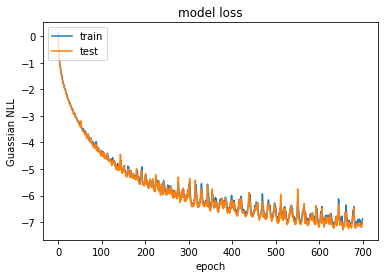

In [32]:
plt.plot(np.arange(len(loss_list)),loss_list)
plt.plot(np.arange(len(val_loss_list)),val_loss_list)
plt.title('model loss')
plt.ylabel('Guassian NLL')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Testing scipt

My idea of the testing script. 
It takes the inverse simulator prediction (Y -> X^)  
Pass X^ to mock_simulator to get Y^   
evaluate performance from Y to Y^  
I don't know if the data is being shuffled at all could contribute too the poor performance

In [33]:
x_preds = test_model(torch.Tensor(Y))
mock_simulator = tf.keras.models.load_model('mock_simulator2.0')
print(x_preds.shape)
means = x_preds.detach().numpy()[:,:2]
final_preds = mock_simulator(means).numpy()    
# for i,d in enumerate(final_preds):
#     print(Y[i],d)
print(final_preds)

torch.Size([3022, 5])
[[0.51021767 0.71815175]
 [0.5661755  0.61477345]
 [0.6109186  0.53642464]
 ...
 [0.21551341 0.5752425 ]
 [0.15411384 0.6686329 ]
 [0.07030879 0.83226365]]


In [34]:
check_acc(X,means,margin=.05)

Correct = 909 / 3022


0.30079417604235603

In [35]:
check_acc(Y,final_preds,margin=.05)

Correct = 913 / 3022


0.30211780277961614

In [36]:
values = x_preds.detach().numpy()
C = np.ones((values.shape[0],1,3))
for i,c in enumerate(C):
    c[:,1] = X[i,0] / X[:,0].max()
    c[:,2] = X[i,1] / X[:,1].max()
C = C.reshape(-1,3)

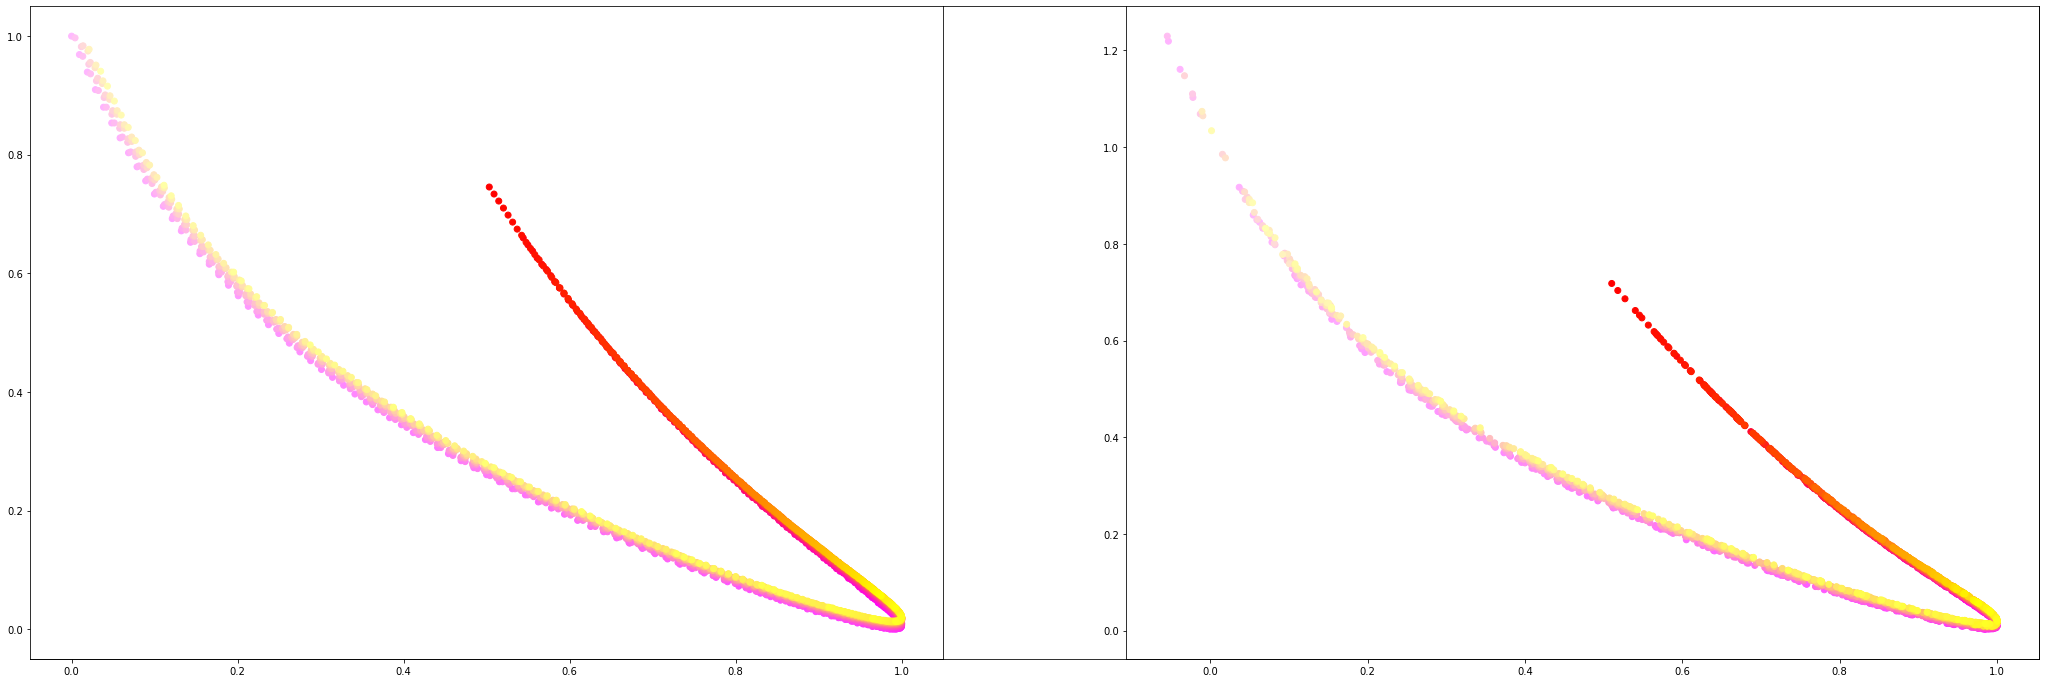

In [37]:
fig, axes = plt.subplots(figsize=(36, 12))
axes.get_xaxis().set_visible(False) # remove erroreas graph axis
axes.get_yaxis().set_visible(False)


xlim = [Y[:,0].min(),Y[:,0].max()]
ylim = [Y[:,1].min(),Y[:,1].max()]


ax = fig.add_subplot(121)
plt.scatter(Y[:,0],Y[:,1], c=C)
ax = fig.add_subplot(122)
#ax.set_xlim(xlim)
#ax.set_ylim(ylim)
plt.scatter(final_preds[:,0],final_preds[:,1], c=C)

plt.show()

In [38]:
def getCovEllip(cov,pos):
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    theta = np.linspace(0, 2*np.pi, 1000);
    ellipsis = (np.sqrt(eigenvalues[None,:]) * eigenvectors) @ [np.sin(theta), np.cos(theta)] + pos.reshape(2,1)
    return ellipsis

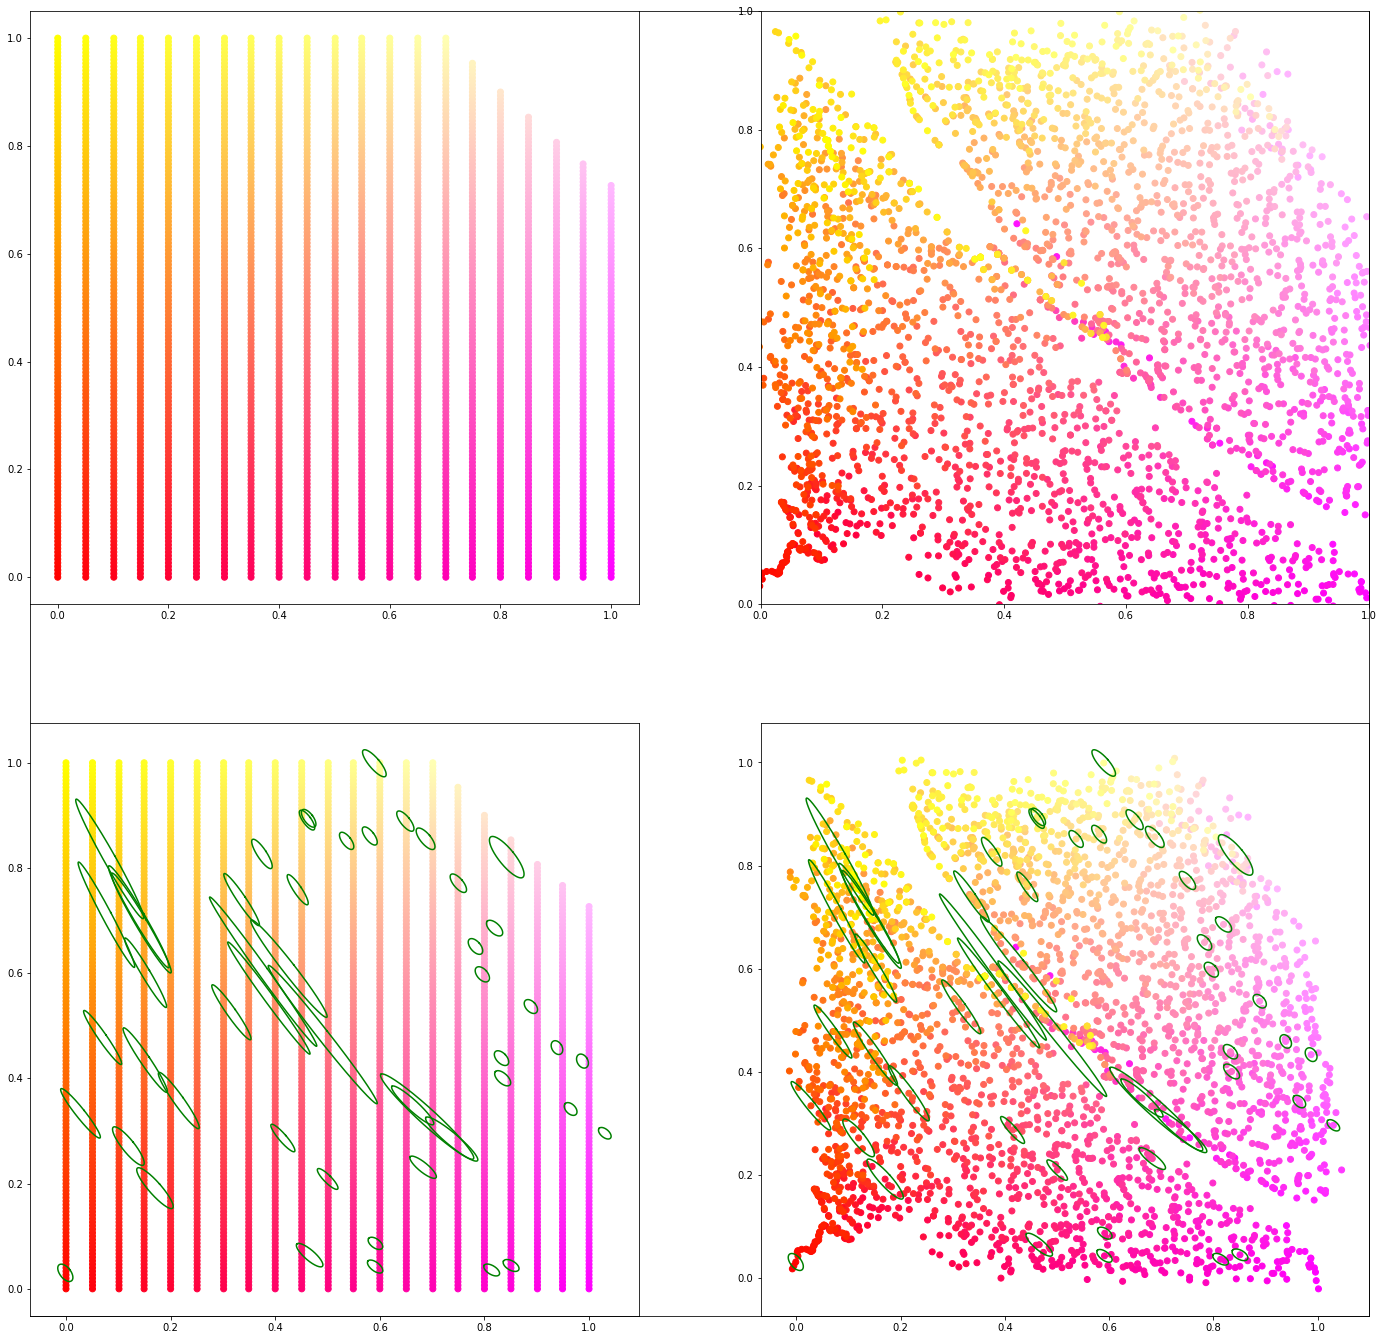

In [39]:
pred_means = x_preds.detach().numpy()[:,:2] # get meansd 

values = x_preds.detach().numpy()
fig, axes = plt.subplots(figsize=(24, 24))
axes.get_xaxis().set_visible(False) # remove erroneos graph axis
axes.get_yaxis().set_visible(False)

xlim = [X[:,0].min(),X[:,0].max()] # calculate limits for input data to set plot axis
ylim = [X[:,1].min(),X[:,1].max()]

num_ellipse = 50
ellipses = []
for i in range(num_ellipse):
    i = np.random.randint(values.shape[0])
    cov = values[i,2:]
    pos = values[i,:2]
    cov = formCovMatrix(cov)
    ellipses.append(getCovEllip(cov,pos))

ax = fig.add_subplot(221)
plt.scatter(X[:,1],X[:,0], c=C)
ax = fig.add_subplot(222)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.scatter(pred_means[:,1],pred_means[:,0], c=C)
ax = fig.add_subplot(224)
plt.scatter(pred_means[:,1],pred_means[:,0], c=C)
for ellipse in ellipses:
    plt.plot(ellipse[1,:], ellipse[0,:],"g")
ax = fig.add_subplot(223)
plt.scatter(X[:,1],X[:,0], c=C)
for ellipse in ellipses:
    plt.plot(ellipse[1,:], ellipse[0,:],"g")
plt.show()

## Load Best Model
Open Saved model run on all data.  
Denomalize data parameter predictions for testing with cadence simulator

In [17]:
test_model = model.DistModelBatchNorm(2,5)
test_model.load_state_dict(torch.load("99acc-batchnorm-relu"))

<All keys matched successfully>

In [18]:
stack = np.hstack((final_preds,Y))
print(stack.shape)
denorm_data = scaler.inverse_transform(stack)
print(denorm_data)
print(denorm_data.min(axis=0))

(3022, 4)
[[ 1.00755815e+03  5.87251847e-06  3.77500000e+00  8.28000000e+10]
 [ 1.08216577e+03  5.22668590e-06  4.23000000e+00  7.70000000e+10]
 [ 1.09777969e+03  5.09996494e-06  4.65200000e+00  7.20000000e+10]
 ...
 [ 7.84171571e+02  5.12562138e-06  3.49000000e-01  7.31000000e+10]
 [ 7.18374144e+02  5.63592595e-06 -5.84000000e-01  8.30000000e+10]
 [ 6.89544952e+02  5.90454561e-06 -1.43300000e+00  9.60000000e+10]]
[ 5.8707693e+02  2.8921875e-06 -1.8230000e+00  3.2400000e+10]


In [19]:
deX = denorm_data[:,:2]
raw_X = data_raw[:,:2]

In [20]:
np.savetxt("predictions", denorm_data[:,:2])

In [21]:
import pandas as pd 
pd.DataFrame(denorm_data[:,:2]).to_csv("predictions.csv")